In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from fetch_yuriy_data import get_yuriy_data
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
X, Y, meta_data = get_yuriy_data(samples_around=100)

print(X.shape)
print(Y.shape)
print(meta_data)

(1388, 200, 19)
(1388,)
{'id': '201512101936.D091BB44', 'tag': 'NK-data import (auto)', 'sampFreq': 200, 'num_samples': 285800, 'channel_names': array(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'], dtype='<U3'), 'binsuV': 1}


In [3]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1110, 200, 19)
(278, 200, 19)
(1110,)
(278,)


In [4]:
import warnings
warnings.filterwarnings('ignore')

n_trials, n_t, n_ch = X.shape
latencies = np.arange(n_t)
alphas = np.logspace(-2, 8, 11)

ridge_pipe = make_pipeline(
      RobustScaler(),
      RidgeClassifierCV(alphas=alphas,
                        cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=0),
                        scoring='balanced_accuracy',
                        fit_intercept=True)
)

best_lat, best_score = None, 0
all_scores = {}
for t in latencies:
    print(f"Processing latency {t}", end=" ")
    X_t = X_train[:, t, :]
    # Add error handling and validation
    try:
        cv_scores = cross_val_score(ridge_pipe, X_t, y_train,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1),
                                    scoring='balanced_accuracy',
                                    n_jobs=-1)
        all_scores[t] = cv_scores
        mean_bacc = cv_scores.mean()
        print(f" mean_bacc: {mean_bacc}")
        if mean_bacc > best_score:
            best_score, best_lat = mean_bacc, t
            print(f"  New best score found: {mean_bacc:.3f}")
    except Exception as e:
        print(f"  Error processing time point {t}: {str(e)}")
        continue

print("\nResults Summary:")
print(f"Best latency: {best_lat}")
print(f"Relative to press: {(best_lat - (n_t//2)) / 200:.4f} s")
print(f"Cross-validation balanced accuracy: {best_score:.3f}")

Processing latency 0  mean_bacc: 0.525234438984439
  New best score found: 0.525
Processing latency 1  mean_bacc: 0.5360370597870598
  New best score found: 0.536
Processing latency 2  mean_bacc: 0.5485111735111735
  New best score found: 0.549
Processing latency 3  mean_bacc: 0.5477323914823915
Processing latency 4  mean_bacc: 0.5594610682110682
  New best score found: 0.559
Processing latency 5  mean_bacc: 0.5405167017667016
Processing latency 6  mean_bacc: 0.5243161343161342
Processing latency 7  mean_bacc: 0.5405493155493156
Processing latency 8  mean_bacc: 0.543227886977887
Processing latency 9  mean_bacc: 0.5324243886743887
Processing latency 10  mean_bacc: 0.5198521411021411
Processing latency 11  mean_bacc: 0.5260698198198198
Processing latency 12  mean_bacc: 0.5360285772785772
Processing latency 13  mean_bacc: 0.5413775301275301
Processing latency 14  mean_bacc: 0.548519656019656
Processing latency 15  mean_bacc: 0.5342352579852581
Processing latency 16  mean_bacc: 0.539576459

In [5]:
# Re-fit on full training set (85 %) with best latency
X_train_best = X_train[:, best_lat, :]
X_test_best  = X_test[:,  best_lat, :]

ridge_pipe.fit(X_train_best, y_train)
print('DONE TRAINING')
print(f'Alpha: {ridge_pipe.named_steps["ridgeclassifiercv"].alpha_}')

DONE TRAINING
Alpha: 1.0


In [6]:
# Testing the model
test_score = ridge_pipe.score(X_test_best, y_test)
print(f"Test set balanced accuracy: {test_score:.3f}")

predictions = ridge_pipe.predict(X_test_best)
print("\nClassification Report:")
print(classification_report(y_test, predictions))


Test set balanced accuracy: 0.773

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.79      0.78       139
           2       0.78      0.76      0.77       139

    accuracy                           0.77       278
   macro avg       0.77      0.77      0.77       278
weighted avg       0.77      0.77      0.77       278



In [7]:
# Feature importance
channel_names = meta_data['channel_names']
coefs = list(ridge_pipe.named_steps['ridgeclassifiercv'].coef_)

sorted_coefs = sorted(list(zip(channel_names, coefs)), key=lambda x: abs(x[1]), reverse=True)

for channel, coef in sorted_coefs:
    print(f"{channel}: {coef:.3f}")

O2: 0.683
T5: -0.531
C4: 0.166
F4: -0.086
F8: -0.085
O1: -0.083
F7: 0.082
Pz: -0.075
P4: -0.073
F3: -0.065
T6: 0.063
Fp2: -0.048
P3: 0.044
Fp1: 0.043
Cz: 0.043
T3: -0.040
T4: 0.017
Fz: -0.004
C3: -0.003


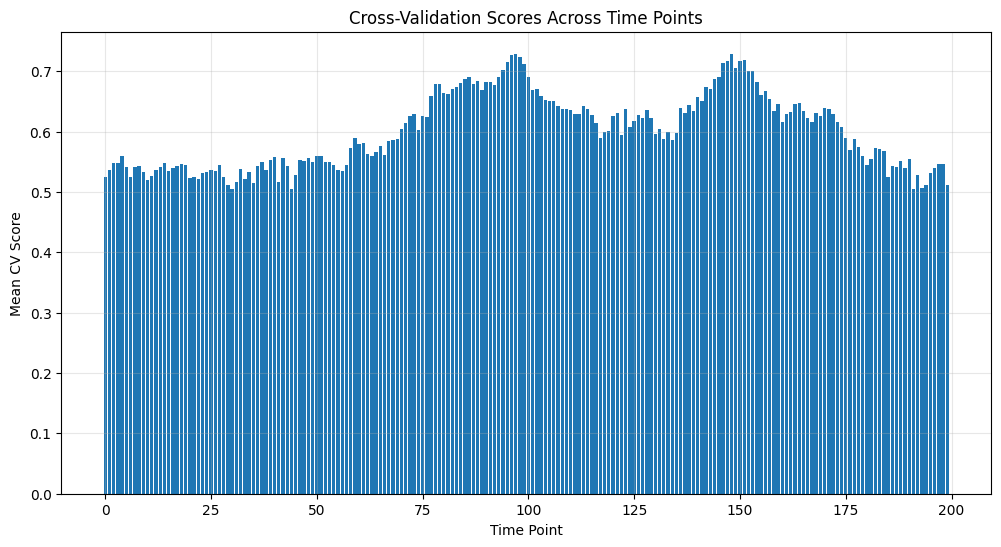

In [8]:
# CV scores of all latencies
mean_cv_scores = [cv_scores.mean() for cv_scores in all_scores.values()]

# Plot CV scores as bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_cv_scores)), mean_cv_scores)
plt.xlabel('Time Point')
plt.ylabel('Mean CV Score')
plt.title('Cross-Validation Scores Across Time Points')
plt.grid(True, alpha=0.3)
plt.show()
